Put some basic use cases for automated backtest/trading

## Setup

In [12]:
import twsq
from twsq.alpha import Alpha
import pandas as pd
import numpy as np
import requests
import util

In [13]:
from twsq.utils import get_twsqroot
get_twsqroot()

C:\Users\joshu\Documents\TWSQ Library


'C:\\Users\\joshu\\Documents\\TWSQ Library'

In [14]:
import datetime

class MinuteShortCloseStrategy(Alpha):
    def prepare(self):
        """
        Set up the strategy parameters.
        """
        self.symbol = 'ETH'
        self.dollar_exposure = 6
        self.position_opened = False
        self.last_trade_time = None

    def rebalance(self):
        """
        On each minute, check the state:
          - If no position is open, enter a short position on ETH.
          - If a position is open and one minute has passed, close the position.
        """
        current_time = datetime.datetime.now(datetime.UTC)

        if not self.position_opened:
            try:
                price = self.get_current_price(self.symbol + '/USD')
            except Exception as e:
                print(f"Error fetching price for {self.symbol}: {e}")
                return

            qty = - (self.dollar_exposure / price)
            target = {self.symbol: qty}

            self.trade_to_target(target, quote='USD', leverage = 2, route=True)

            self.position_opened = True
            self.last_trade_time = current_time

        # If a position is already open, check if one minute has elapsed.
        else:
            elapsed = (current_time - self.last_trade_time).total_seconds()
            if elapsed >= 60:
                # Close the position by setting the target position to 0.
                target = {self.symbol: 0}
                self.trade_to_target(target, quote='USD', leverage = 1, route=True)
                print(f"{current_time} - Closing short position on {self.symbol} after {elapsed:.0f} seconds")
                self.position_opened = False


In [15]:
import datetime

class MinuteLongCloseStrategy(Alpha):
    def prepare(self):
        """
        Set up the strategy parameters.
        """
        self.symbol = 'ETH'
        self.dollar_exposure = 6
        self.position_opened = False
        self.last_trade_time = None

    def rebalance(self):
        """
        On each minute, check the state:
          - If no position is open, enter a short position on ETH.
          - If a position is open and one minute has passed, close the position.
        """
        current_time = datetime.datetime.now(datetime.UTC)

        if not self.position_opened:
            try:
                price = self.get_current_price(self.symbol + '/USD')
            except Exception as e:
                print(f"Error fetching price for {self.symbol}: {e}")
                return

            qty = (self.dollar_exposure / price)
            target = {self.symbol: qty}

            self.trade_to_target(target, quote='USD', route=True)

            self.position_opened = True
            self.last_trade_time = current_time

        # If a position is already open, check if one minute has elapsed.
        else:
            elapsed = (current_time - self.last_trade_time).total_seconds()
            if elapsed >= 60:
                # Close the position by setting the target position to 0.
                target = {self.symbol: 0}
                self.trade_to_target(target, quote='USD', leverage = 1, route=True)
                print(f"{current_time} - Closing short position on {self.symbol} after {elapsed:.0f} seconds")
                self.position_opened = False


## Backtest

In [4]:
backtest_result = MinuteShortCloseStrategy.run_backtest(start_ts='20230101')

Running MinuteShortCloseStrategy backtest: 100.00% done | Total PnL (USDT): -7 | Duration (s): 9   

<Axes: xlabel='Date'>

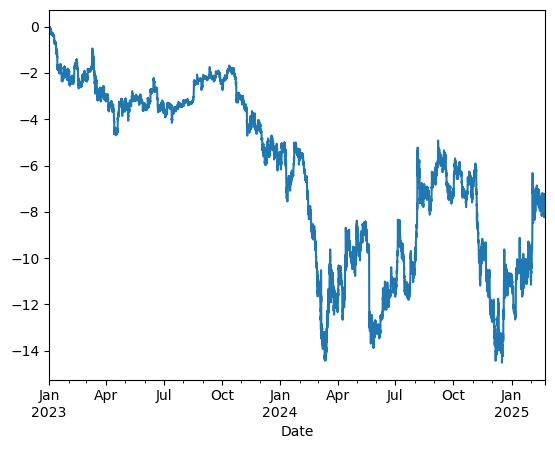

: 

In [ ]:
backtest_result.pos_pnl['port_val'].plot()

## Live

In [ ]:
MinuteLongCloseStrategy.run_live(freq='1m')

24-Feb-25 23:44:13: INFO: 🌱 Live trader initiated
24-Feb-25 23:44:14: INFO: Websocket connected
24-Feb-25 23:44:14: INFO: MinuteLongCloseStrategy: Initial positions: None
24-Feb-25 23:45:02: INFO: Websocket connected
24-Feb-25 23:45:02: INFO: MinuteLongCloseStrategy: 🚀 Rebalance complete: Created 1 new order(s).
24-Feb-25 23:45:02: INFO: MinuteLongCloseStrategy: 🟢 Order to buy 0.0024 ETH/USD closed: 0.0024 filled @ 2496.6
2025-02-25 04:46:00.926236+00:00 - Closing short position on ETH after 60 seconds
24-Feb-25 23:46:01: INFO: MinuteLongCloseStrategy: 🚀 Rebalance complete: Created 1 new order(s).
24-Feb-25 23:46:01: INFO: MinuteLongCloseStrategy: 🟢 Order to sell 0.0024 ETH/USD closed: 0.0024 filled @ 2492.34


In [5]:
MinuteShortCloseStrategy.run_live(freq='1m')

23-Feb-25 13:52:33: INFO: 🌱 Live trader initiated
23-Feb-25 13:52:33: INFO: Websocket connected
23-Feb-25 13:52:34: INFO: MinuteShortCloseStrategy: Initial positions: None
23-Feb-25 13:53:00: INFO: Websocket connected
23-Feb-25 13:53:01: ERROR: Order to sell 0.0021384046788294375 ETH/USD rejected
23-Feb-25 13:53:01: ERROR: kraken {"error":["EOrder:Reduce only:Non-ECP"]}
23-Feb-25 13:53:01: ERROR: Traceback (most recent call last):
  File "c:\users\joshu\documents\twsq library\twsq\twsq\twsq\exec\runner.py", line 68, in run
    self._run()
  File "c:\users\joshu\documents\twsq library\twsq\twsq\twsq\exec\runner.py", line 47, in _run
    self.alpha.rebalance()
  File "C:\Users\joshu\AppData\Local\Temp\ipykernel_40796\3555271720.py", line 31, in rebalance
    self.trade_to_target(target, quote='USD', leverage = 2, route=True)
  File "c:\users\joshu\documents\twsq library\twsq\twsq\twsq\alpha\base.py", line 285, in trade_to_target
    self.create_order(
  File "c:\users\joshu\documents\tws

: 